## Module 4 Final Project - Pulsar Star Classification

* Jonathan Bardey 
* Flatiron School Data Science


## Introduction
 * For this project, we will use Neural Networks and Deep Learning Models as well as more traditional Machine Learning Models to classify pulsar star candidates
 * The dataset (HTRU2) contains statistics of a sample of pulsar candidates collected during the High Time Resolution Universe Survey (Source: https://archive.ics.uci.edu/ml/datasets/HTRU2)
 * Per the data source:
     * Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter .

     * As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes.

     * Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation . Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.

 #### Data Attributes
 * Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency . The remaining four variables are similarly obtained from the DM-SNR curve. (DM = dispersion measure.  SNR = signal-to-noise ratio)

    1. Mean of the integrated profile.
    2. Standard deviation of the integrated profile.
    3. Excess kurtosis of the integrated profile.
    4. Skewness of the integrated profile.
    5. Mean of the DM-SNR curve.
    6. Standard deviation of the DM-SNR curve.
    7. Excess kurtosis of the DM-SNR curve.
    8. Skewness of the DM-SNR curve.
    9. Class (1: pulsar, 0: non-pulsar)


In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
random_state = 1
np.random.seed(1)

from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


Using TensorFlow backend.


#### Obtain the Data

In [2]:
#read dataset into pandas datafram and preview 
data = pd.read_csv('pulsar_stars.csv')
display(data.head())
display(data.shape)

,Mean IP,STD IP,Kurtosis IP,Skewness IP,Mean DM-SNR,STD DM-SNR,Kurtosis DM-SNR,Skewness DM-SNR,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


(17898, 9)

As we can see we have 17,898 rows with 9 columns each - 8 attributes and the target class. 

#### Scrub Data?

In [3]:
#check for null values
print(data.isnull().sum())

Mean IP            0
STD IP             0
Kurtosis IP        0
Skewness IP        0
Mean DM-SNR        0
STD DM-SNR         0
Kurtosis DM-SNR    0
Skewness DM-SNR    0
target_class       0
dtype: int64


There are no null/missing values in the dataset, so we can move on to Exploratory Data Analysis.

### EDA

In [4]:
#Preview the columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
Mean IP            17898 non-null float64
STD IP             17898 non-null float64
Kurtosis IP        17898 non-null float64
Skewness IP        17898 non-null float64
Mean DM-SNR        17898 non-null float64
STD DM-SNR         17898 non-null float64
Kurtosis DM-SNR    17898 non-null float64
Skewness DM-SNR    17898 non-null float64
target_class       17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [5]:
#Look at five point statistics for each of our columns
data.describe()

,Mean IP,STD IP,Kurtosis IP,Skewness IP,Mean DM-SNR,STD DM-SNR,Kurtosis DM-SNR,Skewness DM-SNR,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


In [6]:
#rename target column
data.rename(columns = {'target_class' : 'Target'}, inplace=True)
data.head()

,Mean IP,STD IP,Kurtosis IP,Skewness IP,Mean DM-SNR,STD DM-SNR,Kurtosis DM-SNR,Skewness DM-SNR,Target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [7]:
#split dataset into features and target
feats = data.drop('Target', axis = 1)
target = data.Target

#### Class Imbalance

0    16259
1     1639
Name: Target, dtype: int64


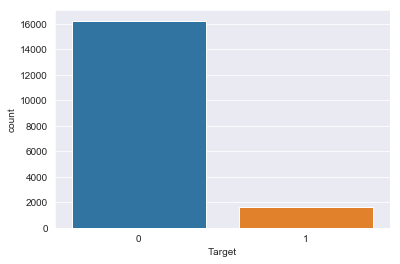

9.16% of the 17898 candidates were classified as pulsar stars.


In [8]:
#lets check and plot occurences of our target variable 'deposit'
print(target.value_counts())
sns.countplot(target)
plt.show()
print(f'{round(sum(target == 1) / len(target)*100, 2)}% of the {len(target)} candidates were classified as pulsar stars.')

#### We will address class imbalance with Synthetic Minority Oversampling SMOTE on our training data before we begin modeling.

#### Visualize Data

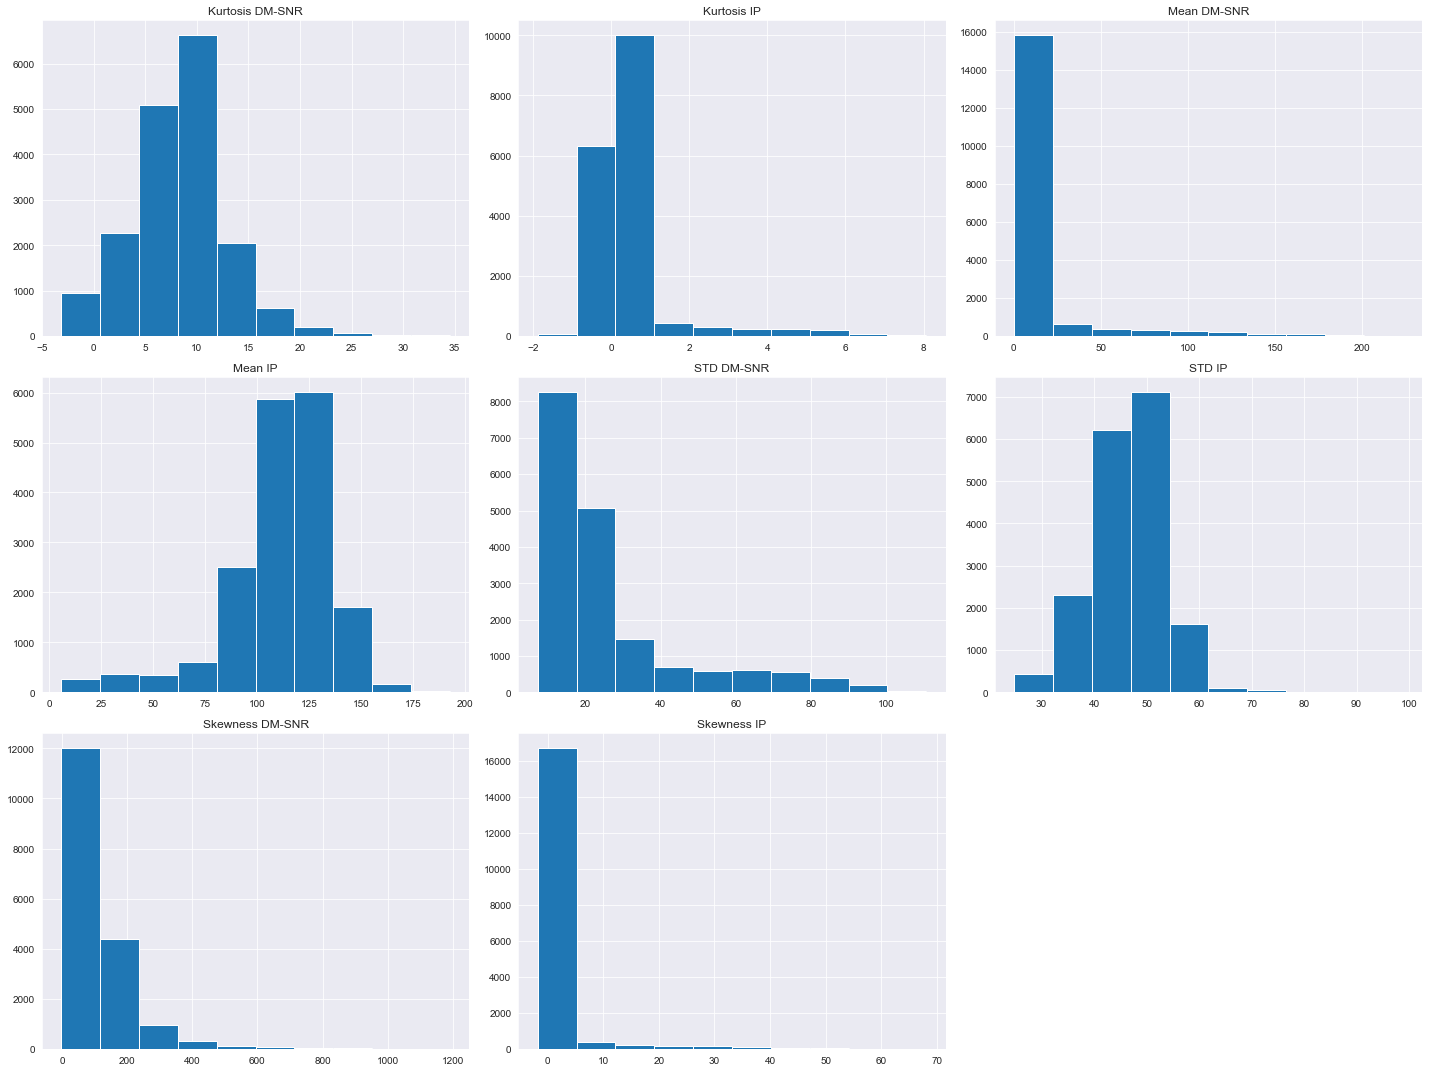

In [9]:
#Plot histogram of each column
feats.hist(figsize=(20,15))
plt.tight_layout()
plt.show()

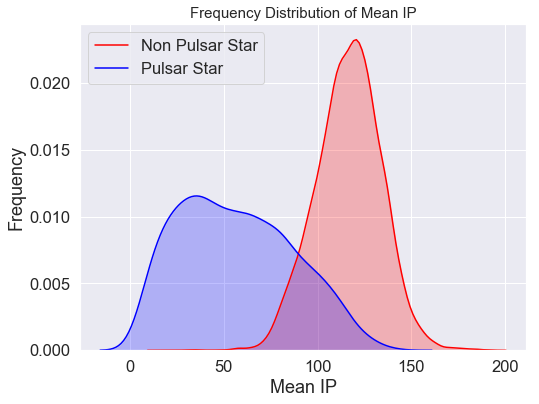

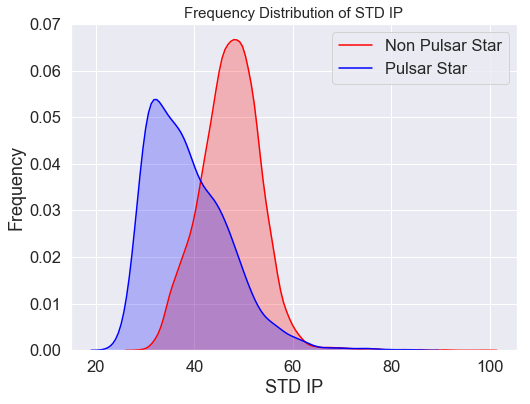

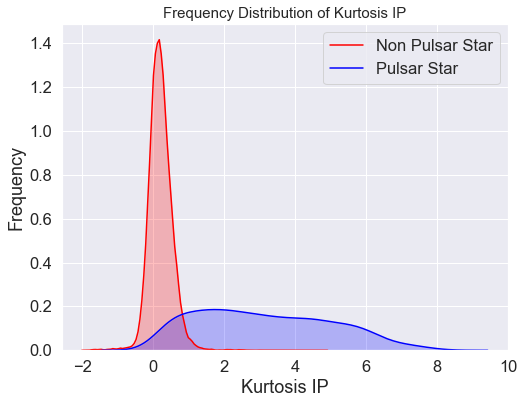

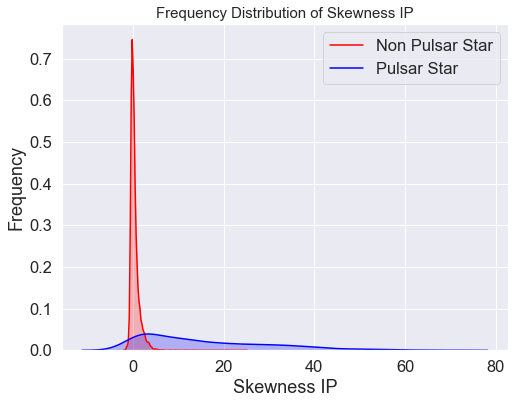

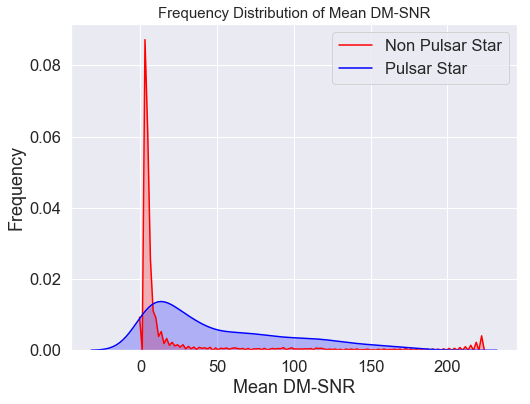

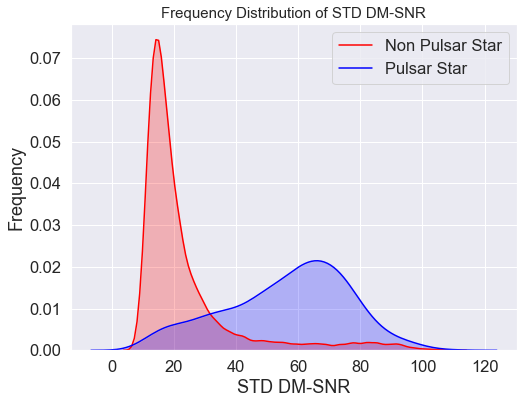

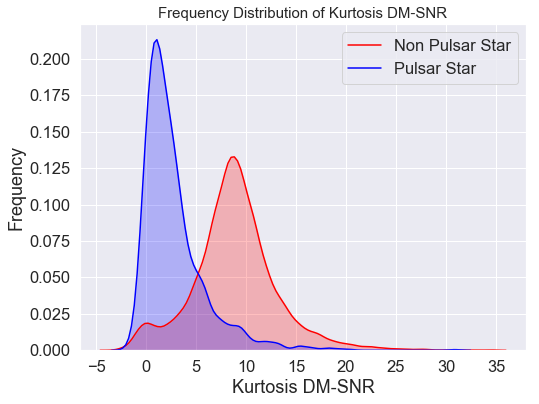

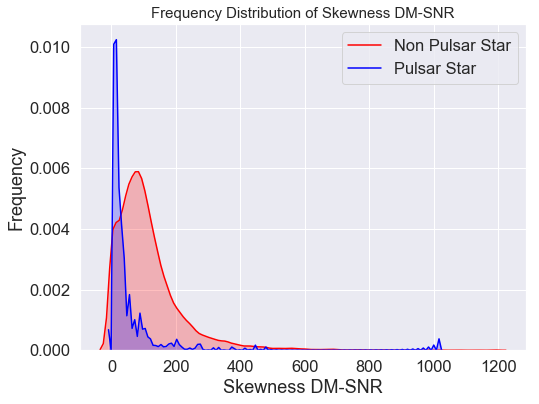

In [111]:
#Look at distribution of features by target class
for col in feats.columns:
    plt.figure(figsize = (8,6))
    sns.kdeplot(data[col][(data['Target'] == 0)], color="Red", shade = True)
    sns.kdeplot(data[col][(data['Target'] == 1)], color="Blue", shade= True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend(["Non Pulsar Star","Pulsar Star"],loc="best")
    plt.title('Frequency Distribution of {}'.format(col), fontsize = 15)
    plt.show()

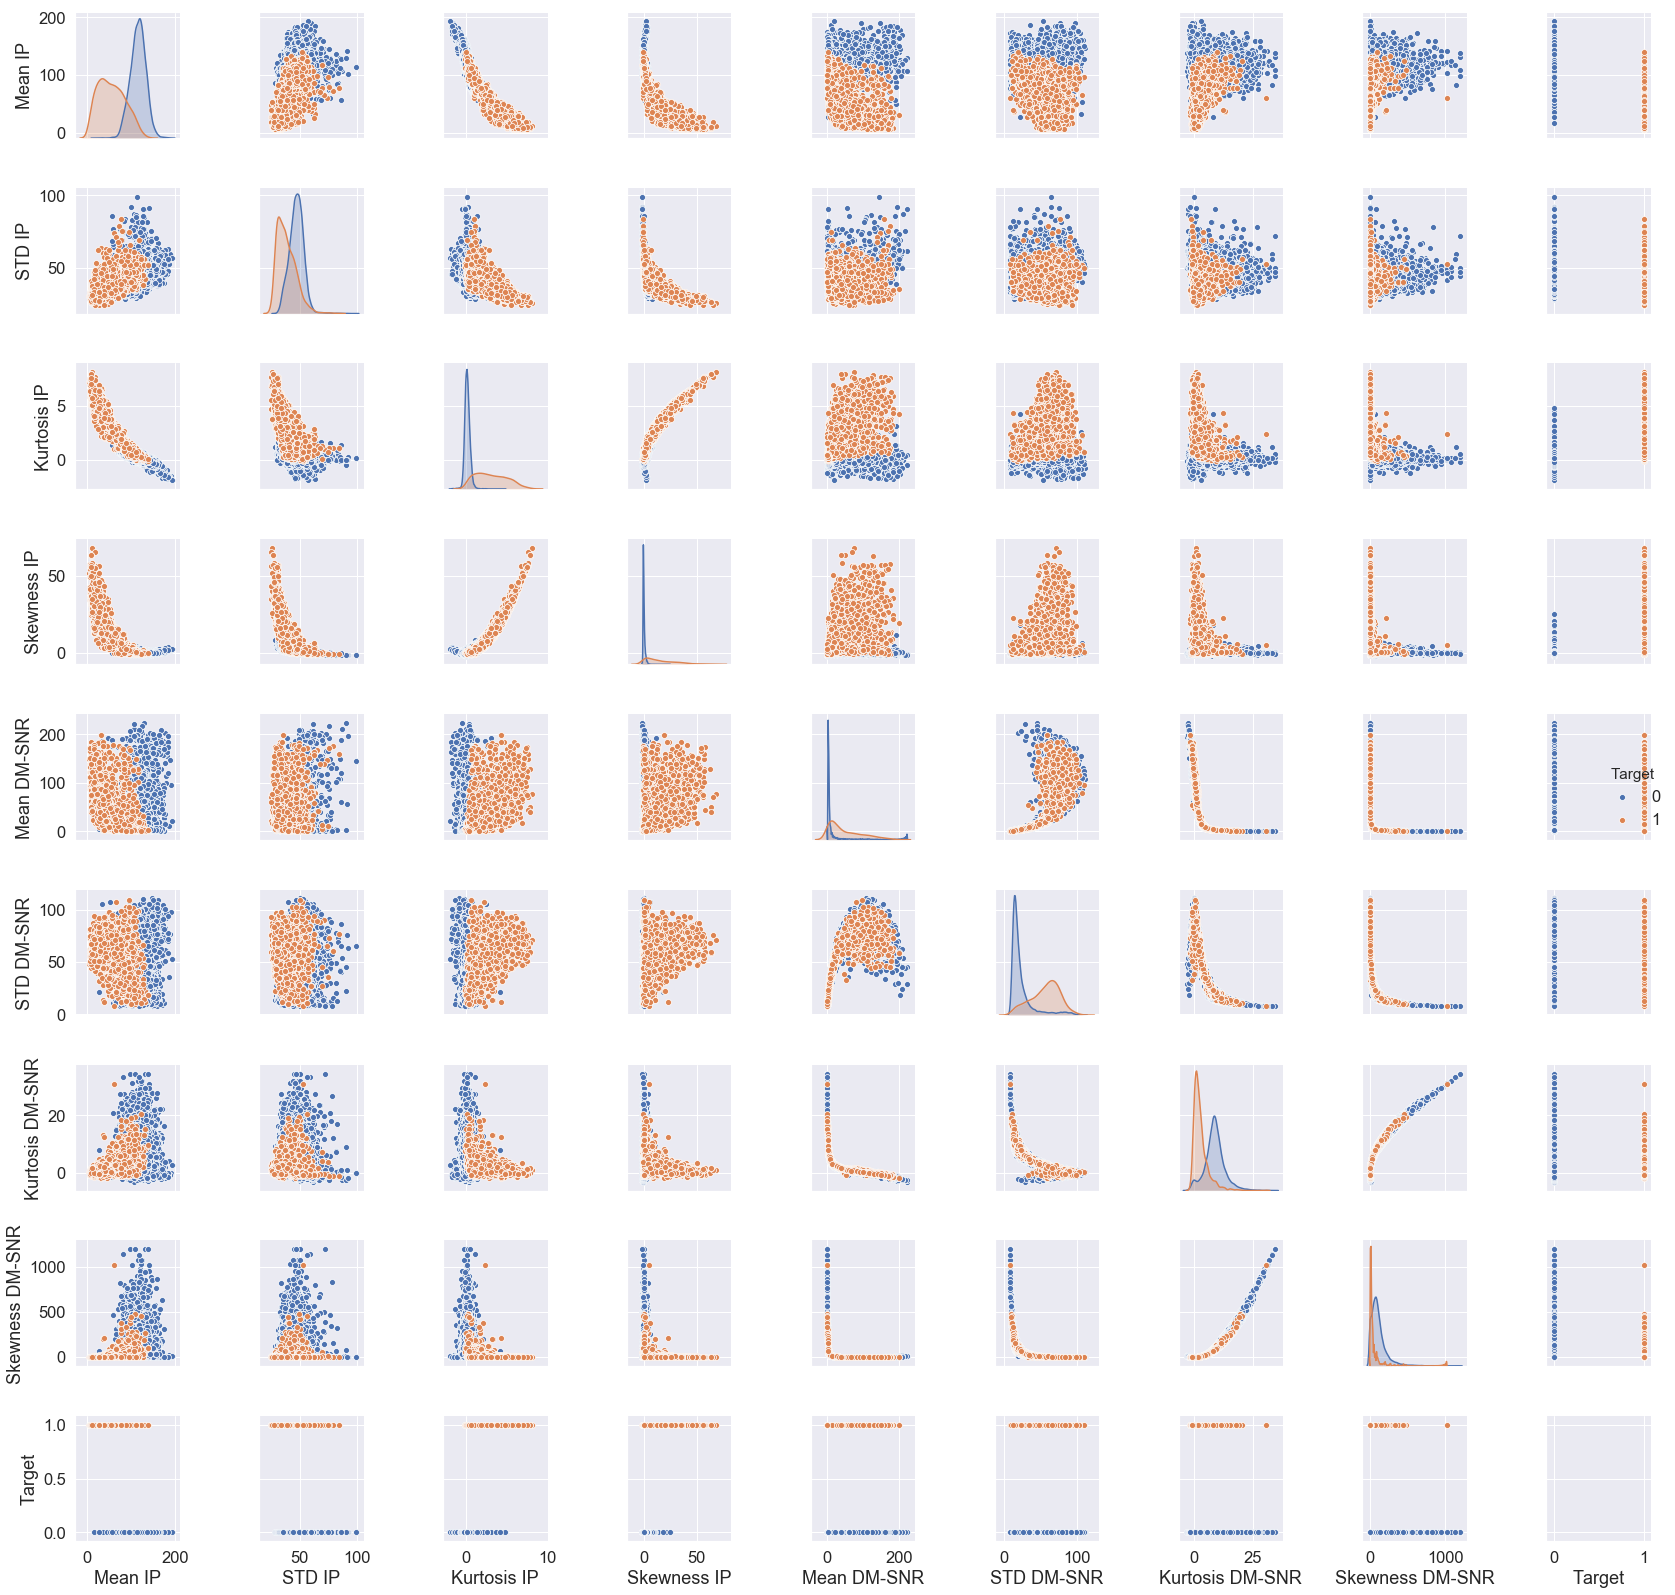

In [11]:
#See distribution and relation between our features
sns.set(font_scale=1.5)
sns.pairplot(data, hue = 'Target')
plt.tight_layout()
plt.show()

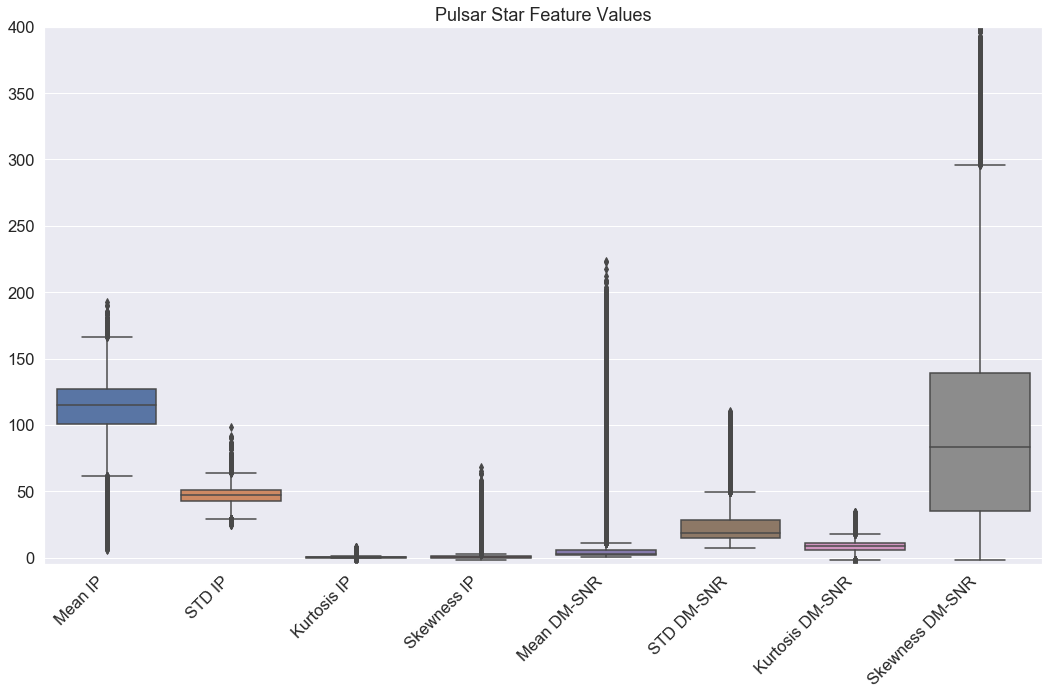

In [12]:
# Boxplot of features to inspect scale and distribution
plt.figure(figsize=(15,10))
sns.boxplot(data=feats)
plt.ylim(-5, 400)
plt.title('Pulsar Star Feature Values', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Feature Scaling with MinMax Scaler

 * Before modeling we want to scale our data so all values are within the range of 0 to 1.  This is important to keep weights in proportion and make Neural Network training more efficient.

In [13]:
#Scale features with MinMax Scaler
scaler = MinMaxScaler()
scaled_feats = scaler.fit_transform(feats)
scaled_df = pd.DataFrame(scaled_feats, columns=feats.columns)
scaled_df['Target'] = target
scaled_df.head()

,Mean IP,STD IP,Kurtosis IP,Skewness IP,Mean DM-SNR,STD DM-SNR,Kurtosis DM-SNR,Skewness DM-SNR,Target
0,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890,0
1,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443,0
2,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610,0
3,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581,0
4,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369,0


In [14]:
scaled_df.shape

(17898, 9)

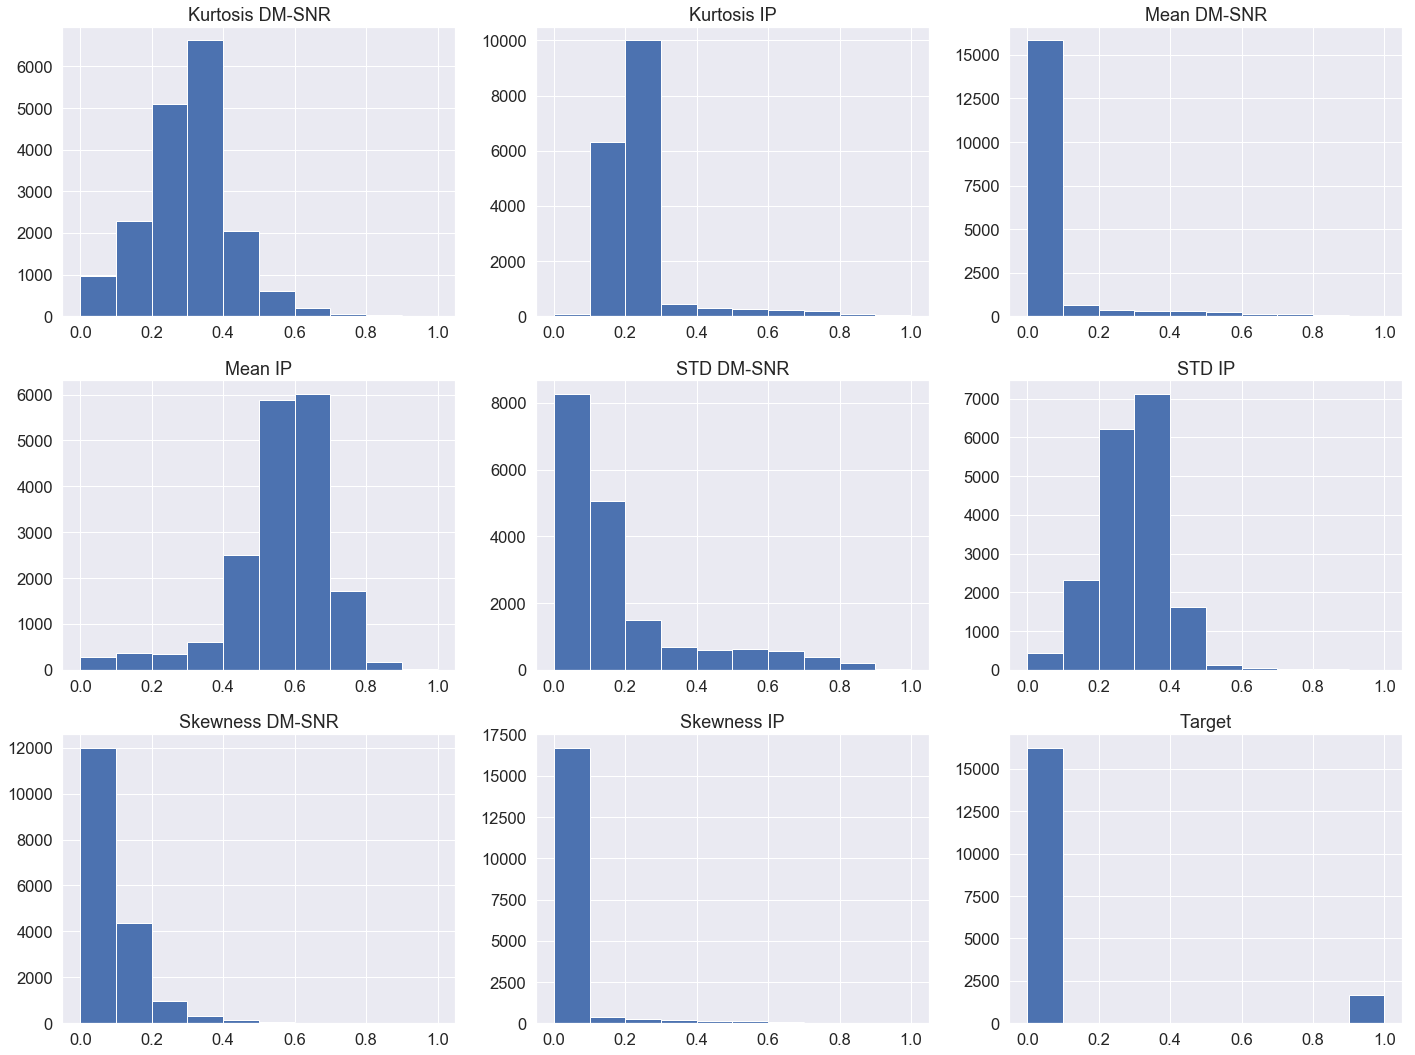

In [15]:
#View distribution of scaled features
scaled_df.hist(figsize=(20,15))
plt.tight_layout()
plt.show()

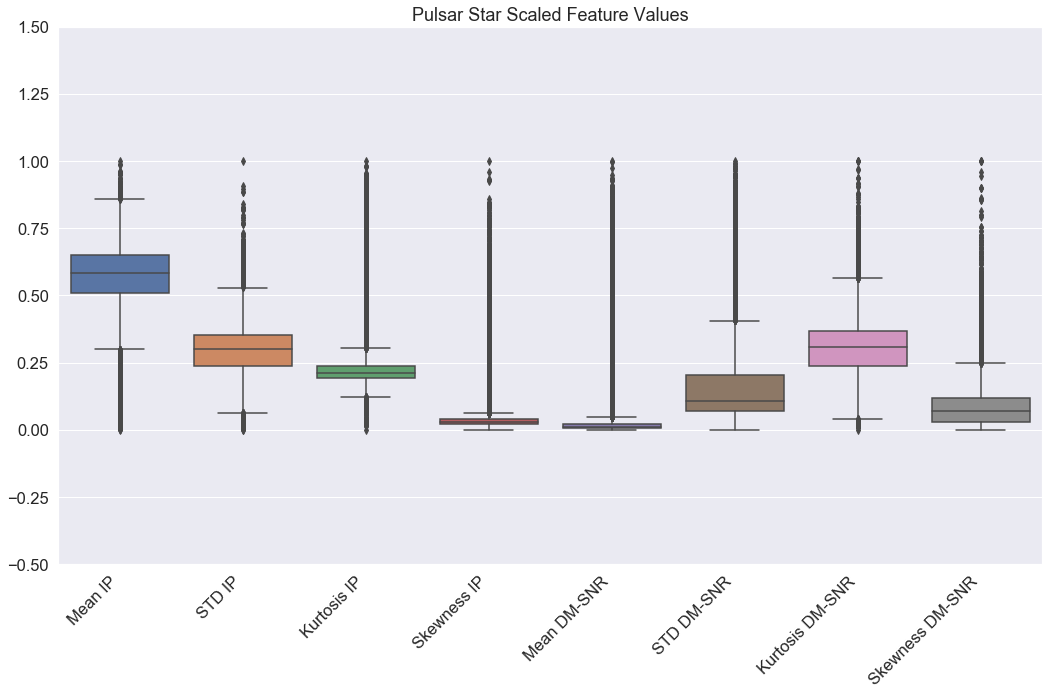

In [16]:
# Boxplots of scaled features
plt.figure(figsize=(15,10))
sns.boxplot(data=scaled_df.drop('Target', axis=1))
plt.ylim(-0.5, 1.5)
plt.title('Pulsar Star Scaled Feature Values', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

 * Distributions are unchanged but feature data now lies between 0 and 1 and is ready for modeling.

#### Before we begin modeling we will split our data into training and test data.  Then perform SMOTE on the train data to fix the class imbalance.

In [17]:
#split features and target
X = scaled_df.drop('Target', axis=1)
y = scaled_df.Target
#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
#check shapes of our split data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12528, 8), (12528,), (5370, 8), (5370,))

In [18]:
#check class balance of train data
y_train.value_counts()

0    11379
1     1149
Name: Target, dtype: int64

In [19]:
#perform SMOTE upsampling on train data
X_train, y_train = SMOTE(random_state=random_state).fit_sample(X_train, y_train)

In [20]:
#check class balance of our upsampled target data
pd.Series(y_train).value_counts()

1    11379
0    11379
dtype: int64

In [21]:
#check class balance of our un-sampled test data
y_test.value_counts()

0    4880
1     490
Name: Target, dtype: int64

#### Convert Target Data to Categorical for Classification with Keras

In [22]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [23]:
y_train.shape, y_test.shape

((22758, 2), (5370, 2))

## Modeling - Deep Learning
 * We will build a number of Neural Networks with the goal of optimizing model architecture and parameters to achieve the best scoring metrics to classify Pulsar Stars.

### Model 1: Two hidden layers and softmax activation

In [24]:
#Build Model 1
np.random.seed(1)
model1 = Sequential()
#first hidden layer
model1.add(Dense(50, activation='relu', input_dim=8))
#second hidden layer
model1.add(Dense(25, activation='relu'))
#output layer (0 and 1)
model1.add(Dense(2, activation='softmax'))

#### Next we will compile Model 1 using 'sgd' as our optimizer, categorical crossentropy for our loss function and Accuracy for our scoring metric.

In [25]:
#Compile Model 1
model1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

#### Review Model 1 architecture:

In [26]:
#View Model 1 summary
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                450       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,777
Trainable params: 1,777
Non-trainable params: 0
_________________________________________________________________


#### Fit model using 50 epochs, batch size of 64 and 20% validation data:

In [27]:
model1_history = model1.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 18206 samples, validate on 4552 samples
Epoch 1/50
18206/18206 [==============================] - 1s 52us/step - loss: 0.4156 - acc: 0.8553 - val_loss: 0.4434 - val_acc: 0.8021
Epoch 2/50
18206/18206 [==============================] - 1s 40us/step - loss: 0.2433 - acc: 0.9172 - val_loss: 0.3642 - val_acc: 0.8436
Epoch 3/50
18206/18206 [==============================] - 1s 40us/step - loss: 0.2111 - acc: 0.9280 - val_loss: 0.3323 - val_acc: 0.8530
Epoch 4/50
18206/18206 [==============================] - 1s 41us/step - loss: 0.1990 - acc: 0.9321 - val_loss: 0.3139 - val_acc: 0.8623
Epoch 5/50
18206/18206 [==============================] - 1s 39us/step - loss: 0.1937 - acc: 0.9336 - val_loss: 0.3669 - val_acc: 0.8489
Epoch 6/50
18206/18206 [==============================] - 1s 38us/step - loss: 0.1906 - acc: 0.9336 - val_loss: 0.3173 - val_acc: 0.8645
Epoch 7/50
18206/18206 [==========

Training Accuracy peaks close to 95% and Validation Accuracy around 90%.   Loss levels out around 0.16 for Training set and 0.24 for Validation set.

#### Build functions to plot the training and validation loss and accuracy:

In [28]:
def plot_loss(history): 
    plt.figure(figsize=(12,6))
    plt.grid(zorder=0, linestyle='--')
    plt.scatter(history.epoch, history.history['loss'], c='purple', s=50, alpha=0.5, label = 'Training Loss')
    plt.scatter(history.epoch, history.history['val_loss'], c='red', s=50, alpha=0.5, label = 'Validation Loss')
    plt.title('Training Loss vs Validation Loss', fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [29]:
def plot_accuracy(history): 
    plt.figure(figsize=(12,6))
    plt.grid(zorder=0, linestyle='--')
    plt.scatter(history.epoch, history.history['acc'], c='blue', s=50, alpha=0.5, label = 'Training Acc')
    plt.scatter(history.epoch, history.history['val_acc'], c='orange', s=50, alpha=0.5, label = 'Validation Acc')
    plt.title('Training Accuracy vs Validation Accuracy', fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#### Plot Model 1 Train/Val Loss and Accuracy

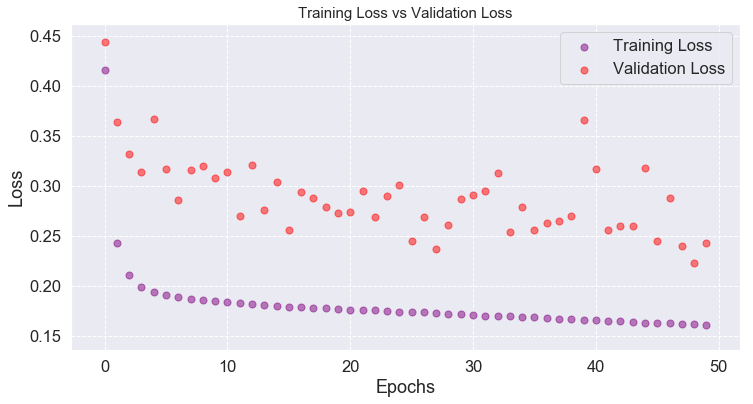

In [30]:
plot_loss(model1_history)

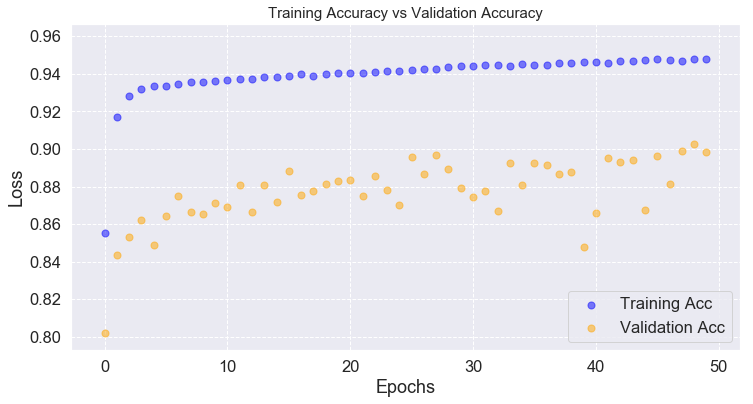

In [31]:
plot_accuracy(model1_history)

### Classification Report and Confusion Matrix to Evaluate Model 1 with holdout Test Data

In [32]:
#Build and view Classification Report
probs1 = model1.predict(X_test)
y_pred1 = np.argmax(probs1, axis=1)
y_true = np.argmax(y_test, axis=1)
print('-' *60)
print(classification_report(y_true, y_pred1))
print('-' *60)

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4880
           1       0.82      0.91      0.86       490

    accuracy                           0.97      5370
   macro avg       0.91      0.95      0.92      5370
weighted avg       0.98      0.97      0.97      5370

------------------------------------------------------------


In [33]:
#Function to plot a confusion matrix given true and predicted values from a model
def plot_conf_matrix(y_true, y_pred, model_name=None, cmap='Blues'):
    class_names = ['Non-Pulsar', 'Pulsar']
    cm = confusion_matrix(y_true, y_pred)
    dataframe = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(8,6))
    sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap, fmt='.00f', annot_kws={'size':12})
    if model_name:
        plt.title(f'Confusion Matrix: {model_name}', fontsize=15)
    else:
        plt.title('Confusion Matrix', fontsize=15)
    plt.ylabel('True Class' ,fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.show()

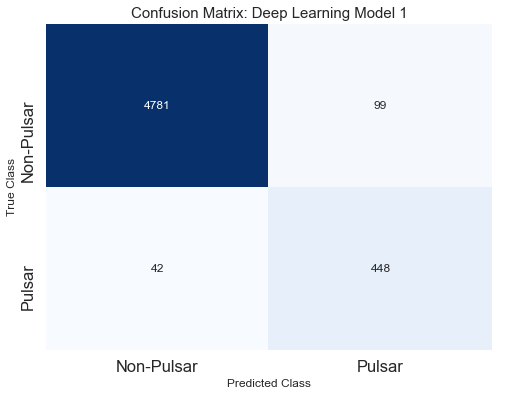

In [34]:
#Plot confustion matrix for Model 1
plot_conf_matrix(y_true, y_pred1, model_name='Deep Learning Model 1')

In [35]:
#Look at loss and accuracy for test set
model1_scores = model1.evaluate(X_test, y_test)
model1_scores

5370/5370 [==============================] - 0s 16us/step


[0.12312433986024483, 0.9737430167597766]

In [36]:
#create a dictionary to keep track of Accuracy scores
acc_scores = {}
acc_scores["model1"] = round(model1_scores[1],3)
acc_scores

{'model1': 0.974}

### Initial Thoughts on Model 1
 * The model performs well with a 97.4% Test Accuracy Score and weighted averages of 97% as well for Recall, Precision and F1.
 * Predictably, with the unbalanced dataset, despite training on balanced data it does not do as well at predicting the minority class of Pulsar Stars.  This model does better on Recall than Precision, meaning we have fewer False Negatives than False Positives.  
 * False Positive means we the model predicts a star is a pulsar but it is not.  False Negative means the model predicts a start is not a pulsar when it actually is.  There is not a clear answer in which we would rather minimize, but seems to me that False Negatives would lead scientists to lose out on insights to be gained from these rare events.  Ideally, of course, we would minimize both but in evaluating models we will give some weight to minimizing False Negatives.  This model has 42 False Negatives vs 99 False Positives; a good start!
 * We will attempt some more models - try adding layers and tuning some hyperparameters to see if we can improve on Model 1.

### Gridsearch to Tune Hyperparameters of Neural Network Model

In [37]:
# Function to create model with similar architecture to Model 1, required for KerasClassifier.  
# code courtesy of https://keras.io/examples/mnist_sklearn_wrapper/
def make_model(optimizer='sgd'):
    #Create model
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=8))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    #Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [38]:
#Wrap Keras model in Keras classifier to use with scikit-learn
my_classifier = KerasClassifier(build_fn=make_model, verbose=1)

In [39]:
#Define Gridsearch parameters
epochs = [25, 50, 75]
batches = [16, 32, 64]
optimizers = ['sgd', 'rmsprop', 'adam']

#Create hyperparameter grid
param_grid = dict(epochs=epochs, batch_size=batches, optimizer=optimizers)

In [40]:
#Create GridSearch - commented out to save time when re-running notebook
#validator = GridSearchCV(estimator=my_classifier, param_grid=param_grid, n_jobs=-1, cv=3)
#Fit GridSearch
#validator.fit(X_train, y_train)

In [41]:
#validator.best_params_

In [42]:
#saved results from GridSearch
grid_search_results = {'batch_size': 64, 'epochs': 75, 'optimizer': 'rmsprop'}
grid_search_results

{'batch_size': 64, 'epochs': 75, 'optimizer': 'rmsprop'}

For our next model we will use these optimized hyperparameters with the basic structure from Model 1.

### Model 2: Two hidden layers with Optimized Hyperparameters from Gridsearch 

In [43]:
#Build Model 2
np.random.seed(1)
model2 = Sequential()
model2.add(Dense(50, activation='relu', input_dim=8))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(2, activation='softmax'))

In [44]:
#Compile Model 2
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
#View Model 2 summary
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                450       
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 52        
Total params: 1,777
Trainable params: 1,777
Non-trainable params: 0
_________________________________________________________________


In [46]:
model2_history = model2.fit(X_train, y_train, batch_size=64, epochs=75, validation_split=0.2)

Train on 18206 samples, validate on 4552 samples
Epoch 1/75
18206/18206 [==============================] - 1s 34us/step - loss: 0.2692 - acc: 0.9138 - val_loss: 0.3252 - val_acc: 0.8620
Epoch 2/75
18206/18206 [==============================] - 0s 20us/step - loss: 0.1882 - acc: 0.9341 - val_loss: 0.2874 - val_acc: 0.8752
Epoch 3/75
18206/18206 [==============================] - 0s 20us/step - loss: 0.1835 - acc: 0.9364 - val_loss: 0.2686 - val_acc: 0.8858
Epoch 4/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.1803 - acc: 0.9384 - val_loss: 0.3126 - val_acc: 0.8741
Epoch 5/75
18206/18206 [==============================] - 0s 27us/step - loss: 0.1776 - acc: 0.9408 - val_loss: 0.4072 - val_acc: 0.8379
Epoch 6/75
18206/18206 [==============================] - 0s 25us/step - loss: 0.1750 - acc: 0.9417 - val_loss: 0.3489 - val_acc: 0.8550
Epoch 7/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.1727 - acc: 0.9440 - val_loss: 0.2746 - val_acc:

18206/18206 [==============================] - 1s 28us/step - loss: 0.1370 - acc: 0.9558 - val_loss: 0.1409 - val_acc: 0.9328
Epoch 61/75
18206/18206 [==============================] - 0s 27us/step - loss: 0.1364 - acc: 0.9556 - val_loss: 0.1840 - val_acc: 0.9238
Epoch 62/75
18206/18206 [==============================] - 1s 28us/step - loss: 0.1364 - acc: 0.9558 - val_loss: 0.1801 - val_acc: 0.9216
Epoch 63/75
18206/18206 [==============================] - 1s 29us/step - loss: 0.1371 - acc: 0.9552 - val_loss: 0.2438 - val_acc: 0.9049
Epoch 64/75
18206/18206 [==============================] - 1s 38us/step - loss: 0.1370 - acc: 0.9558 - val_loss: 0.2557 - val_acc: 0.9049
Epoch 65/75
18206/18206 [==============================] - 1s 58us/step - loss: 0.1356 - acc: 0.9558 - val_loss: 0.2310 - val_acc: 0.9106
Epoch 66/75
18206/18206 [==============================] - 1s 49us/step - loss: 0.1362 - acc: 0.9551 - val_loss: 0.1904 - val_acc: 0.9183
Epoch 67/75
18206/18206 [=====================

#### Plot Model 2 Train/Val Loss and Accuracy

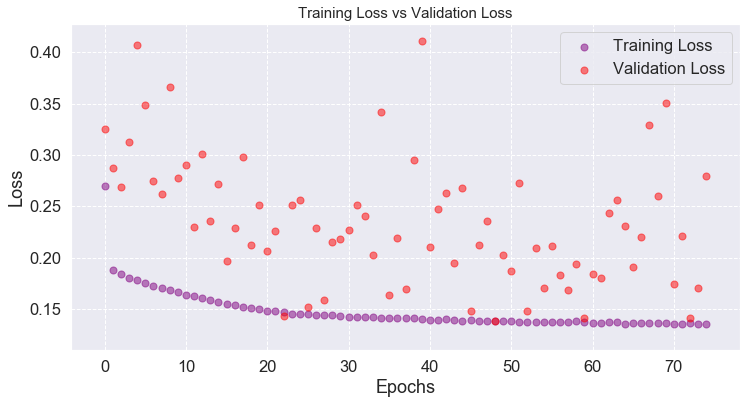

In [47]:
plot_loss(model2_history)

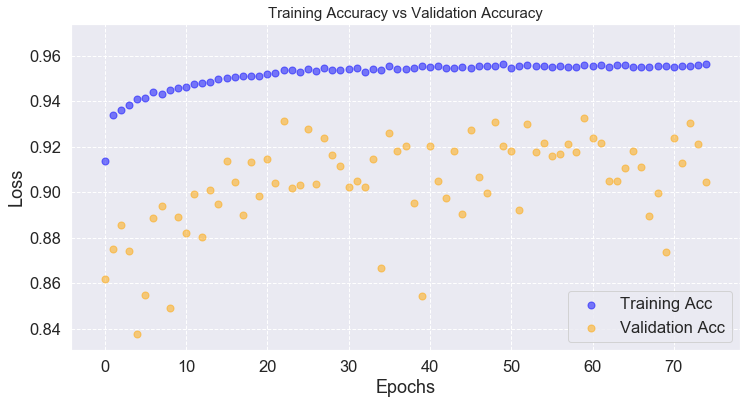

In [48]:
plot_accuracy(model2_history)

#### Evaluate Model 2 using Test Data

In [49]:
#Build and view Classification Report for Model 2
probs2 = model2.predict(X_test)
y_pred2 = np.argmax(probs2, axis=1)
print('-' *60)
print(classification_report(y_true, y_pred2))
print('-' *60)

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4880
           1       0.87      0.91      0.89       490

    accuracy                           0.98      5370
   macro avg       0.93      0.95      0.94      5370
weighted avg       0.98      0.98      0.98      5370

------------------------------------------------------------


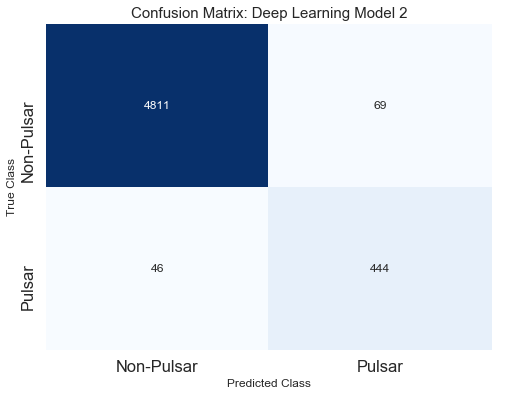

In [50]:
#Plot confustion matrix for Model 2
plot_conf_matrix(y_true, y_pred2, model_name='Deep Learning Model 2')

In [51]:
#Look at loss and accuracy for test set
model2_scores = model2.evaluate(X_test, y_test)
model2_scores

5370/5370 [==============================] - 0s 35us/step


[0.08169855098040632, 0.9785847298481833]

In [52]:
#add accuracy score to dictionary
acc_scores["model2"] = round(model2_scores[1],3)
acc_scores

{'model1': 0.974, 'model2': 0.979}

### Model 2 Thoughts:
 * Accuracy improved a little to 97.9% using the gridsearch optimized hyperparameters, along with 98% for Recall, Precision and F1.
 * For the minority (Pulsar star) class, Recall scored 90% and Precision improved from 82% to 87%.
 * We had a few more False Negatives that with Model 1, but a nice reduction in False Positives.
 * Overall, this was a nice improvement from Model 1 to Model 2 and we will keep the hyerparameters the same and add hidden layers for our next attempt.

### Model 3: Optimized Hyperparameters from Model 2 with Added Hidden Layers

In [53]:
#Build Model 3
np.random.seed(1)
model3 = Sequential()
model3.add(Dense(100, activation='relu', input_dim=8))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(25, activation='relu'))
model3.add(Dense(25, activation='relu'))
model3.add(Dense(2, activation='softmax'))

In [54]:
#Compile Model 3
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
#View Model 3 summary
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               900       
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 52        
Total params: 7,927
Trainable params: 7,927
Non-trainable params: 0
_________________________________________________________________


In [56]:
#fit Model 3
model3_history = model3.fit(X_train, y_train, batch_size=64, epochs=75, validation_split=0.2)

Train on 18206 samples, validate on 4552 samples
Epoch 1/75
18206/18206 [==============================] - 1s 58us/step - loss: 0.2284 - acc: 0.9238 - val_loss: 0.3340 - val_acc: 0.8653
Epoch 2/75
18206/18206 [==============================] - 1s 48us/step - loss: 0.1825 - acc: 0.9370 - val_loss: 0.2339 - val_acc: 0.9047
Epoch 3/75
18206/18206 [==============================] - 1s 54us/step - loss: 0.1765 - acc: 0.9406 - val_loss: 0.2573 - val_acc: 0.8961
Epoch 4/75
18206/18206 [==============================] - 1s 58us/step - loss: 0.1724 - acc: 0.9422 - val_loss: 0.4895 - val_acc: 0.8251
Epoch 5/75
18206/18206 [==============================] - 1s 51us/step - loss: 0.1675 - acc: 0.9446 - val_loss: 0.2708 - val_acc: 0.8981
Epoch 6/75
18206/18206 [==============================] - 1s 40us/step - loss: 0.1637 - acc: 0.9452 - val_loss: 0.1463 - val_acc: 0.9306
Epoch 7/75
18206/18206 [==============================] - 1s 35us/step - loss: 0.1590 - acc: 0.9483 - val_loss: 0.3123 - val_acc:

18206/18206 [==============================] - 1s 42us/step - loss: 0.1304 - acc: 0.9566 - val_loss: 0.2417 - val_acc: 0.8939
Epoch 61/75
18206/18206 [==============================] - 1s 41us/step - loss: 0.1278 - acc: 0.9570 - val_loss: 0.3583 - val_acc: 0.8840
Epoch 62/75
18206/18206 [==============================] - 1s 34us/step - loss: 0.1279 - acc: 0.9575 - val_loss: 0.1870 - val_acc: 0.9225
Epoch 63/75
18206/18206 [==============================] - 1s 36us/step - loss: 0.1303 - acc: 0.9577 - val_loss: 0.1999 - val_acc: 0.9187
Epoch 64/75
18206/18206 [==============================] - 1s 43us/step - loss: 0.1279 - acc: 0.9573 - val_loss: 0.1833 - val_acc: 0.9218
Epoch 65/75
18206/18206 [==============================] - 1s 51us/step - loss: 0.1287 - acc: 0.9563 - val_loss: 0.2092 - val_acc: 0.9187
Epoch 66/75
18206/18206 [==============================] - 1s 39us/step - loss: 0.1266 - acc: 0.9577 - val_loss: 0.2551 - val_acc: 0.9097
Epoch 67/75
18206/18206 [=====================

#### Plot Model 3 Train/Val Loss and Accuracy

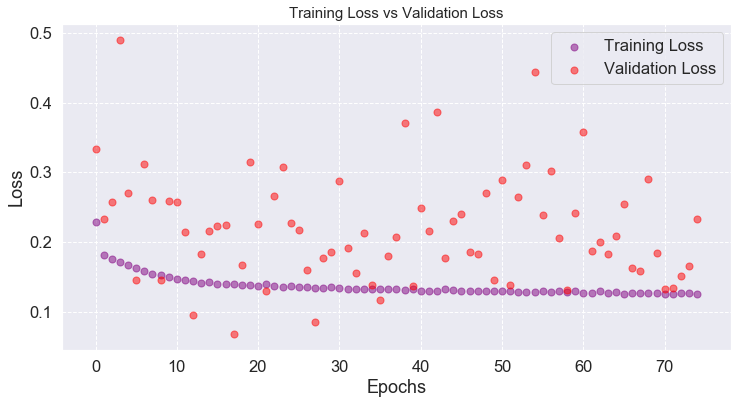

In [57]:
plot_loss(model3_history)

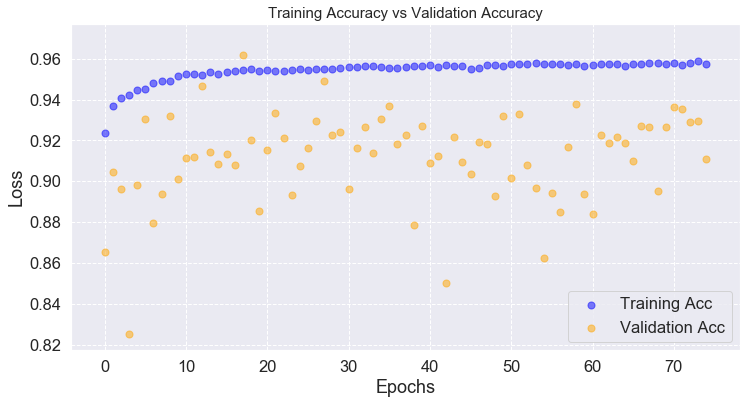

In [58]:
plot_accuracy(model3_history)

#### Evaluate Model 3

In [59]:
#Build and view Classification Report for Model 3
probs3 = model3.predict(X_test)
y_pred3 = np.argmax(probs3, axis=1)
print('-' *60)
print(classification_report(y_true, y_pred3))
print('-' *60)

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4880
           1       0.87      0.90      0.88       490

    accuracy                           0.98      5370
   macro avg       0.93      0.94      0.94      5370
weighted avg       0.98      0.98      0.98      5370

------------------------------------------------------------


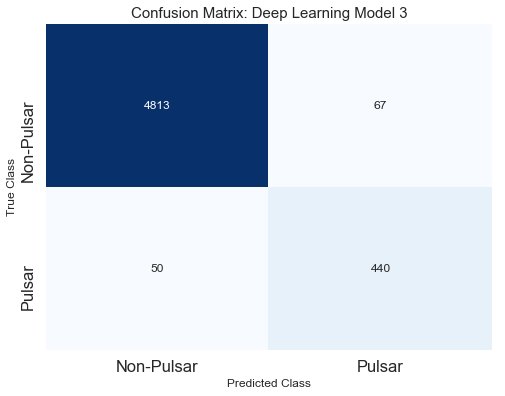

In [60]:
#Plot confustion matrix for Model 3
plot_conf_matrix(y_true, y_pred3, model_name='Deep Learning Model 3')

In [61]:
#Look at loss and accuracy for test set
model3_scores = model3.evaluate(X_test, y_test)
model3_scores

5370/5370 [==============================] - 0s 18us/step


[0.10097530908757747, 0.9782122903695986]

In [62]:
#add accuracy score to dictionary
acc_scores["model3"] = round(model3_scores[1],3)
acc_scores

{'model1': 0.974, 'model2': 0.979, 'model3': 0.978}

### Model 3 Thoughts:
 * Model 3 scores very high in Accuracy, very similar to Model 2.
 * The Precision and Recalls scores are very similar to Model 2 but have more of both False Negatives and False Positives.  
 * The added layers did not improve the model over Model 2 so we will go back to the original architecture with optimized hyperparameters and add weight regularization.

### Model 4: Optimized Hyperparameters with Weight Regularization
 * We will use L2 regularizaion with a lambda of 0.005 (like in the Flatiron lab).  This sets a penalty for larger weights and helps reduce overfitting.

In [63]:
#Build Model 4
from keras import regularizers

np.random.seed(1)
model4 = Sequential()
model4.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_dim=8))
model4.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model4.add(Dense(2, activation='softmax'))

In [64]:
#Compile Model 4
model4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
#View Model 4 summary
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                450       
_________________________________________________________________
dense_13 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 52        
Total params: 1,777
Trainable params: 1,777
Non-trainable params: 0
_________________________________________________________________


In [66]:
model4_history = model4.fit(X_train, y_train, batch_size=64, epochs=75, validation_split=0.2)

Train on 18206 samples, validate on 4552 samples
Epoch 1/75
18206/18206 [==============================] - 1s 43us/step - loss: 0.4127 - acc: 0.9101 - val_loss: 0.4089 - val_acc: 0.8543
Epoch 2/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.2649 - acc: 0.9319 - val_loss: 0.3479 - val_acc: 0.8640
Epoch 3/75
18206/18206 [==============================] - 0s 23us/step - loss: 0.2445 - acc: 0.9332 - val_loss: 0.3261 - val_acc: 0.8728
Epoch 4/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.2341 - acc: 0.9342 - val_loss: 0.3787 - val_acc: 0.8559
Epoch 5/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.2278 - acc: 0.9349 - val_loss: 0.4688 - val_acc: 0.8210
Epoch 6/75
18206/18206 [==============================] - 1s 29us/step - loss: 0.2232 - acc: 0.9360 - val_loss: 0.4431 - val_acc: 0.8236
Epoch 7/75
18206/18206 [==============================] - 0s 26us/step - loss: 0.2196 - acc: 0.9360 - val_loss: 0.3538 - val_acc:

18206/18206 [==============================] - 0s 22us/step - loss: 0.1860 - acc: 0.9471 - val_loss: 0.2219 - val_acc: 0.9088
Epoch 61/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.1854 - acc: 0.9473 - val_loss: 0.2804 - val_acc: 0.8943
Epoch 62/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.1849 - acc: 0.9472 - val_loss: 0.2690 - val_acc: 0.8926
Epoch 63/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.1854 - acc: 0.9460 - val_loss: 0.3423 - val_acc: 0.8691
Epoch 64/75
18206/18206 [==============================] - 0s 23us/step - loss: 0.1852 - acc: 0.9468 - val_loss: 0.3398 - val_acc: 0.8702
Epoch 65/75
18206/18206 [==============================] - 0s 23us/step - loss: 0.1841 - acc: 0.9461 - val_loss: 0.3004 - val_acc: 0.8888
Epoch 66/75
18206/18206 [==============================] - 0s 22us/step - loss: 0.1840 - acc: 0.9472 - val_loss: 0.2317 - val_acc: 0.9047
Epoch 67/75
18206/18206 [=====================

#### Plot Model 4 Train/Val Loss and Accuracy

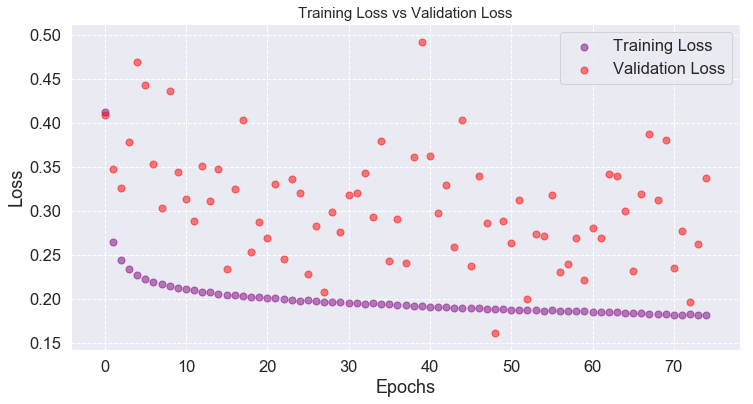

In [67]:
plot_loss(model4_history)

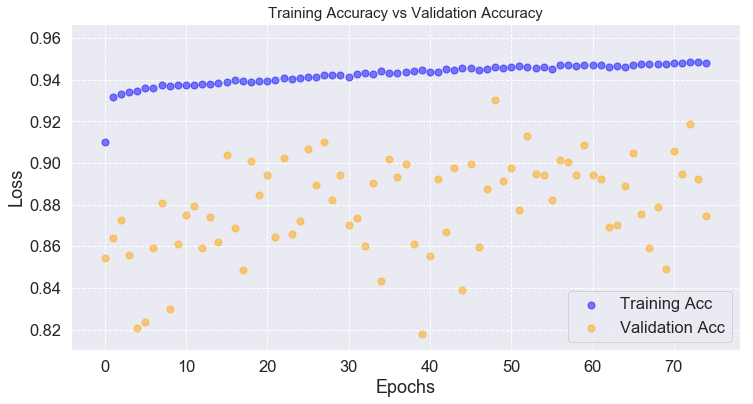

In [68]:
plot_accuracy(model4_history)

#### Evaluate Model 4 using Test Data

In [69]:
#Build and view Classification Report for Model 4
probs4 = model4.predict(X_test)
y_pred4 = np.argmax(probs4, axis=1)
print('-' *60)
print(classification_report(y_true, y_pred4))
print('-' *60)

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4880
           1       0.87      0.89      0.88       490

    accuracy                           0.98      5370
   macro avg       0.93      0.94      0.94      5370
weighted avg       0.98      0.98      0.98      5370

------------------------------------------------------------


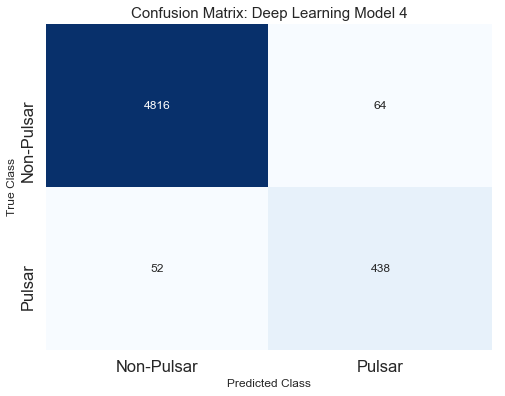

In [70]:
#Plot confustion matrix for Model 4
plot_conf_matrix(y_true, y_pred4, model_name='Deep Learning Model 4')

In [71]:
#Look at loss and accuracy for test set
model4_scores = model4.evaluate(X_test, y_test)
model4_scores

5370/5370 [==============================] - 0s 21us/step


[0.1141431112279439, 0.9783985102420857]

In [72]:
#add accuracy score to dictionary
acc_scores["model4"] = round(model4_scores[1],3)
acc_scores

{'model1': 0.974, 'model2': 0.979, 'model3': 0.978, 'model4': 0.978}

### Model 4 Thoughts:
 * Model 4 ties Model 2 for highest accuracy (rounded to 3 places).  
 * For the minority (Pulsar star) class, Recall was 89% and Precision 88%, with a few more False Negatives and a few less False Positives than Model 2.  It basically performed the same, just slightly shifted At this point we are splitting hairs as each of the models does a very nice job of classifying our dataset.
 * I think we can say that our model is not overfit based on lack of improvement with the L2 regularizaion.
 * For the final Deep Learning model, we will incorporate Dropout Regularizaion.

### Model 5: Optimized Hyperparameters with Dropout Regularizaion
 * We will apply Dropout to our hidden layers.  Dropout randomly selects nodes to be "dropped out" or ignored with a given probability (here we will use 30%) each update cycle.

In [73]:
#Build Model 5
from keras.layers import Dropout

np.random.seed(1)
model5 = Sequential()
model5.add(Dense(50, activation='relu', input_dim=8))
model5.add(Dropout(0.3))
model4.add(Dense(25, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(2, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [74]:
#Compile Model 5
model5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
#View Model 5 summary
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                450       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 102       
Total params: 552
Trainable params: 552
Non-trainable params: 0
_________________________________________________________________


In [76]:
model5_history = model5.fit(X_train, y_train, batch_size=64, epochs=75, validation_split=0.2)

Train on 18206 samples, validate on 4552 samples
Epoch 1/75
18206/18206 [==============================] - 1s 53us/step - loss: 0.3662 - acc: 0.8681 - val_loss: 0.3929 - val_acc: 0.8258
Epoch 2/75
18206/18206 [==============================] - 1s 28us/step - loss: 0.2320 - acc: 0.9205 - val_loss: 0.3099 - val_acc: 0.8642
Epoch 3/75
18206/18206 [==============================] - 1s 30us/step - loss: 0.2137 - acc: 0.9269 - val_loss: 0.3296 - val_acc: 0.8614
Epoch 4/75
18206/18206 [==============================] - 1s 34us/step - loss: 0.2047 - acc: 0.9306 - val_loss: 0.3611 - val_acc: 0.8519
Epoch 5/75
18206/18206 [==============================] - 1s 32us/step - loss: 0.2006 - acc: 0.9315 - val_loss: 0.3012 - val_acc: 0.8721
Epoch 6/75
18206/18206 [==============================] - 1s 30us/step - loss: 0.1973 - acc: 0.9327 - val_loss: 0.2741 - val_acc: 0.8803
Epoch 7/75
18206/18206 [==============================] - 1s 30us/step - loss: 0.1927 - acc: 0.9353 - val_loss: 0.3239 - val_acc:

18206/18206 [==============================] - 1s 31us/step - loss: 0.1601 - acc: 0.9502 - val_loss: 0.2360 - val_acc: 0.9014
Epoch 61/75
18206/18206 [==============================] - 1s 29us/step - loss: 0.1585 - acc: 0.9503 - val_loss: 0.2451 - val_acc: 0.8972
Epoch 62/75
18206/18206 [==============================] - 1s 31us/step - loss: 0.1581 - acc: 0.9511 - val_loss: 0.2500 - val_acc: 0.9003
Epoch 63/75
18206/18206 [==============================] - 1s 30us/step - loss: 0.1578 - acc: 0.9505 - val_loss: 0.2395 - val_acc: 0.9007
Epoch 64/75
18206/18206 [==============================] - 1s 29us/step - loss: 0.1561 - acc: 0.9516 - val_loss: 0.2601 - val_acc: 0.8946
Epoch 65/75
18206/18206 [==============================] - 1s 30us/step - loss: 0.1567 - acc: 0.9503 - val_loss: 0.2379 - val_acc: 0.9086
Epoch 66/75
18206/18206 [==============================] - 1s 32us/step - loss: 0.1581 - acc: 0.9515 - val_loss: 0.2267 - val_acc: 0.9093
Epoch 67/75
18206/18206 [=====================

#### Plot Model 5 Train/Val Loss and Accuracy

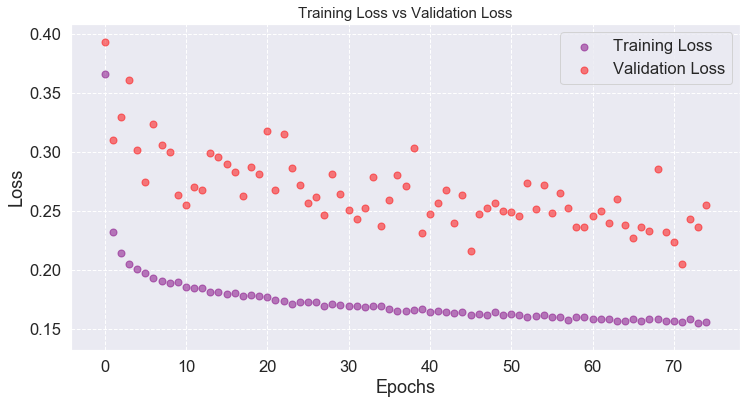

In [77]:
plot_loss(model5_history)

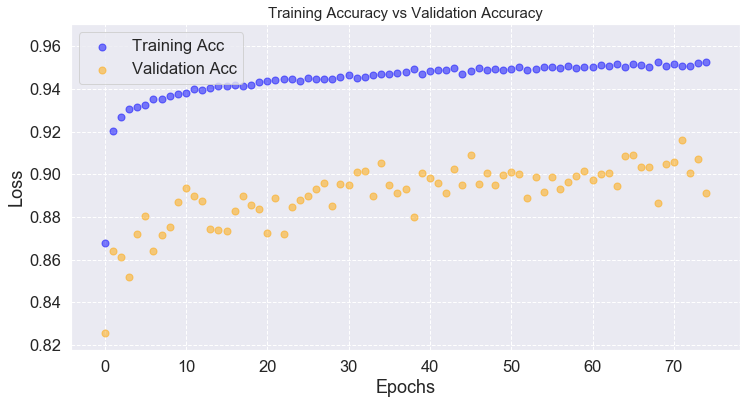

In [78]:
plot_accuracy(model5_history)

#### Evaluate Model 5 using Test Data

In [79]:
#Build and view Classification Report for Model 5
probs5 = model5.predict(X_test)
y_pred5 = np.argmax(probs5, axis=1)
print('-' *60)
print(classification_report(y_true, y_pred5))
print('-' *60)

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4880
           1       0.87      0.90      0.89       490

    accuracy                           0.98      5370
   macro avg       0.93      0.94      0.94      5370
weighted avg       0.98      0.98      0.98      5370

------------------------------------------------------------


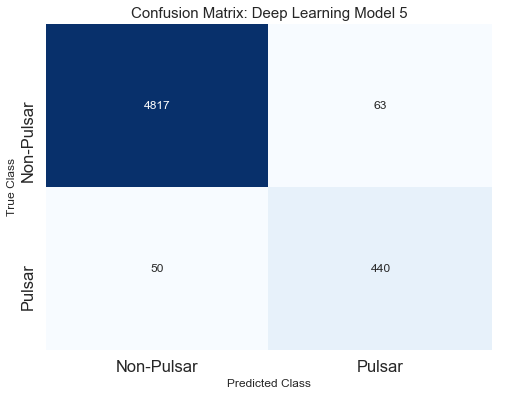

In [80]:
#Plot confustion matrix for Model 5
plot_conf_matrix(y_true, y_pred5, model_name='Deep Learning Model 5')

In [81]:
#Look at loss and accuracy for test set
model5_scores = model5.evaluate(X_test, y_test)
model5_scores

5370/5370 [==============================] - 0s 19us/step


[0.10642210968268873, 0.9789571694599628]

In [82]:
#add accuracy score to dictionary
acc_scores["model5"] = round(model5_scores[1],3)
acc_scores

{'model1': 0.974,
 'model2': 0.979,
 'model3': 0.978,
 'model4': 0.978,
 'model5': 0.979}

### Model 5 Thoughts:
 * Model 5 also achieves almost 98% accuracy and similar scoring metrics to Models 2 and 4.  
 * Again, like the L2 Regularization, this regularizaion technique was not required to optimize our Deep Learning model on this data set, but is certainly a good tool to learn and have in the arsenal for future projects where the dataset is not so easily classified

## Deep Learning Wrap-up:
 * We created five Deep Learning Neural Network Models for the classification of Pulsar Stars.
 * All models performed well, but after running a gridsearch for our optimal optimizer, batch size and number of epochs, additional attempts to improve the model with additional layers or regularization techniques did not improve our model is any significant way.
 * Model 2 was our best model with 97.9% Accuracy and minimized our total of FN and FP with fewer False Negatives, which was our preference.

## Machine Learning Modeling
 * For sake of comparison we will now run a few machine learning models on the same pre-processed data.
 * This will allow for investigation into feature importance, as well as perhaps be more computationally efficient.

#### First let's take a new look at feature correlation with our Target

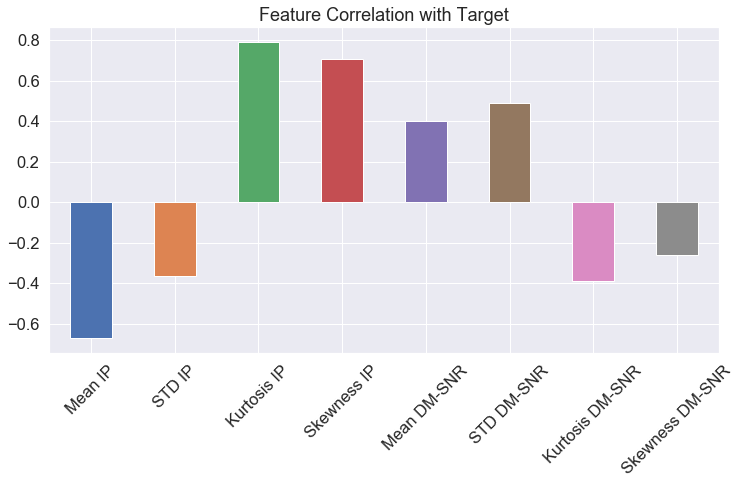

In [113]:
#Plot feature correlation with Target
feats.corrwith(target).plot.bar(figsize=(12,6), grid = True)
plt.xticks(rotation=45)
plt.title('Feature Correlation with Target')
plt.show()

We can see 4 of our Features correlate positively and 4 negatively with our Target class.  

In [84]:
#Perform another train_test split - need 1 dimensional y and SMOTE upsample train data as before
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_train1, y_train1 = SMOTE(random_state=random_state).fit_sample(X_train1, y_train1)


### Decision Tree Model

In [85]:
#Instantiate and fit baseline decision tree
tree = DecisionTreeClassifier(random_state=random_state)
tree.fit(X_train1, y_train1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [86]:
#Build and view Classification Report
y_pred_tree = tree.predict(X_test1)
print('-' *60)
print(classification_report(y_test1, y_pred_tree))
print('-' *60)

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4880
           1       0.66      0.88      0.76       490

    accuracy                           0.95      5370
   macro avg       0.83      0.92      0.86      5370
weighted avg       0.96      0.95      0.95      5370

------------------------------------------------------------


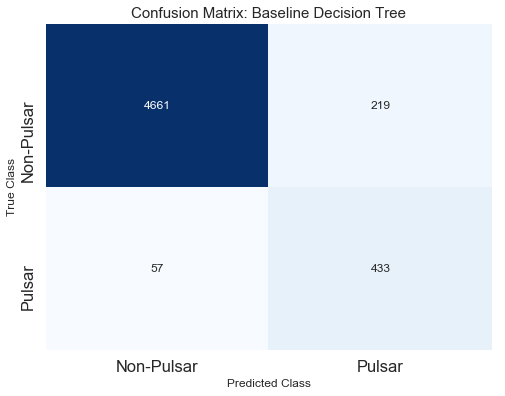

In [87]:
#Plot confustion matrix for Baseline Decision Tree
plot_conf_matrix(y_test1, y_pred_tree, model_name='Baseline Decision Tree')

In [88]:
#Compute Decision Tree Accuracy Score
tree_acc = round(tree.score(X_test1, y_test1),3)
print(f'Decision Tree Accuracy: {round(tree_acc*100,1)}%')
#Add score to dict and display
acc_scores['Decision Tree'] = tree_acc
acc_scores

Decision Tree Accuracy: 94.9%


{'model1': 0.974,
 'model2': 0.979,
 'model3': 0.978,
 'model4': 0.978,
 'model5': 0.979,
 'Decision Tree': 0.949}

While it is our "worst" performing model yet, the Accuracy Score is still a respectable 95%.

In [89]:
# Function to visually inspect feature importances
def plot_feat_imp(model_classifier, data=feats, color='blue', model_name=None):
    importances = model_classifier.feature_importances_
    features = data.columns
    features_importance = pd.DataFrame(importances, index=features, columns=['Importance'])
    sorted_feat_imp = features_importance.sort_values('Importance', axis=0, ascending=False)
    plt.figure(figsize=(12,5))
    plt.title(f'Feature Importance in {model_name} Model', fontsize=18)
    imp = sorted_feat_imp['Importance'].values.tolist()
    plt.bar(range(data.shape[1]), imp, color=color )
    plt.xticks(range(data.shape[1]), sorted_feat_imp.index, rotation=45, ha='center', fontsize=12)
    plt.xlim(-1, data.shape[1])
    plt.ylabel('Importance', fontsize=15)
    plt.tight_layout()
    plt.show()

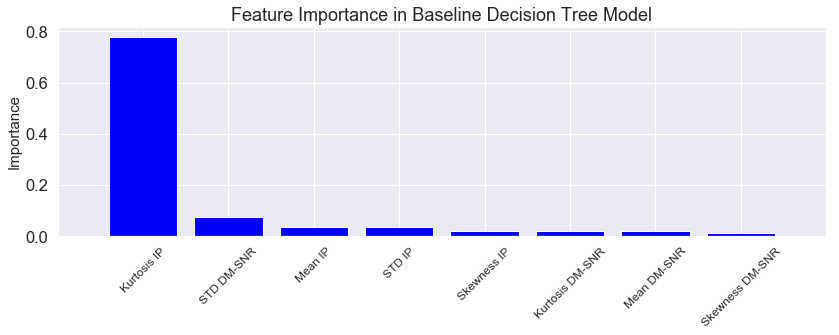

In [90]:
#Visualize Feature Importance
plot_feat_imp(tree, model_name='Baseline Decision Tree')

Wow!  This chart shows that Kurtosis of the Integrated Profile is by far the most important feature making predictions using the Decision Tree.  What kind of accuracy would we get if we used just that feature?

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4880
           1       0.61      0.84      0.71       490

    accuracy                           0.94      5370
   macro avg       0.80      0.89      0.84      5370
weighted avg       0.95      0.94      0.94      5370

------------------------------------------------------------
1 Feature Decision Tree Accuracy: 93.7%
------------------------------------------------------------


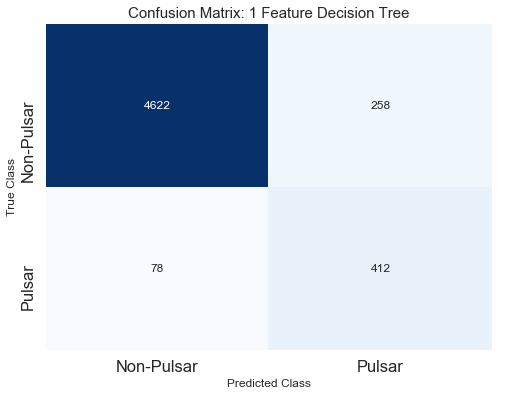

In [91]:
#Build and evaluate 1 Feature Decision Tree
tree2 = DecisionTreeClassifier(max_features=1, random_state=random_state)
tree2.fit(X_train1, y_train1)
y_pred_tree2 = tree2.predict(X_test1)
print('-' *60)
print(classification_report(y_test1, y_pred_tree2))
print('-' *60)
tree2_acc = tree2.score(X_test1, y_test1)
print(f'1 Feature Decision Tree Accuracy: {round(tree2_acc,3)*100}%')
print('-' *60)
plot_conf_matrix(y_test1, y_pred_tree2, model_name='1 Feature Decision Tree')

### Decision Tree Thoughts:
 * A Baseline Decision Tree scores around 95% on Accuracy and weighted Precision, Recall and F1.
 * This model predicts the minority class more often, leading to many more FP, despite a reasonable number of FN.
 * Feature Importance plot showed 1 feature (Kurtosis IP) being by far the most important and a Decision Tree Model with just the 1 feature still scores 93.7% on Accuracy and just a couple percentage points lower on Precision and Recall for the Pulsar Star class.
 

### Random Forest Model

In [92]:
#Instantiate and fit baseline Random Forest
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [93]:
#Build and view Classification Report
y_pred_rf = rf.predict(X_test1)
print('-' *60)
print(classification_report(y_test1, y_pred_rf))
print('-' *60)

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4880
           1       0.86      0.90      0.88       490

    accuracy                           0.98      5370
   macro avg       0.92      0.94      0.93      5370
weighted avg       0.98      0.98      0.98      5370

------------------------------------------------------------


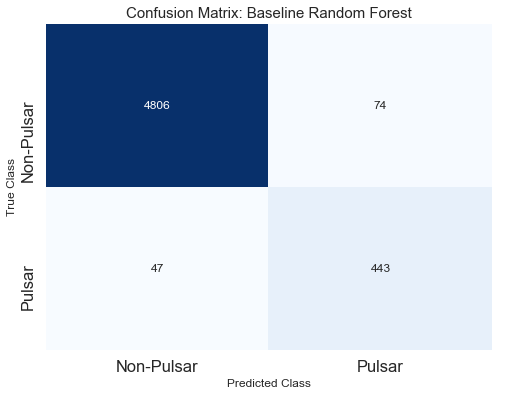

In [94]:
#Plot confustion matrix for Baseline Random Forest
plot_conf_matrix(y_test1, y_pred_rf, model_name='Baseline Random Forest')

In [95]:
#Compute Random Forest Accuracy Score
rf_acc = round(rf.score(X_test1, y_test1),3)
print(f'Random Forest Accuracy: {rf_acc*100}%')
#Add score to dict and display
acc_scores['Random Forest'] = rf_acc
acc_scores

Random Forest Accuracy: 97.7%


{'model1': 0.974,
 'model2': 0.979,
 'model3': 0.978,
 'model4': 0.978,
 'model5': 0.979,
 'Decision Tree': 0.949,
 'Random Forest': 0.977}

Look at this, an out of the box Random Forest classifier scores almost the same Accuracy as our Deep Learning models.  It has just 47 FN and 74 FP - in line with our top models, and before any optimization. 

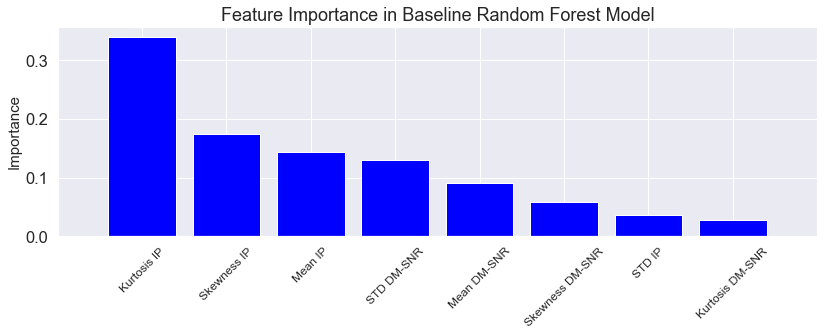

In [96]:
#Visualize Feature Importance
plot_feat_imp(rf, model_name='Baseline Random Forest')

### Random Forest Thoughts:
 * A Baseline Random Forest scores nearly 98% on Accuracy and weighted Precision, Recall and F1 - in line with our top Deep Learning Models, and before doing any optimization.  
 * Kurtosis IP is still the most important feature, but as it has 100 Decision Trees in the forest (default n_estimators) it is not as stark as our baseline Decision Tree, and other features play a more significant role in the model.
 * Considering computational expense, even before optimzation, this is a strong contender for our top model.
 

#### Let's look at one more Machine Learning Algorithm - Support Vector Machine

### SVM Model

In [97]:
#Instantiate and fit baseline SVM, default C and kernel
svm = SVC(C=1.0, kernel='rbf', random_state=random_state)
svm.fit(X_train1, y_train1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [98]:
#Build and view Classification Report
y_pred_svm = svm.predict(X_test1)
print('-' *60)
print(classification_report(y_test1, y_pred_svm))
print('-' *60)

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4880
           1       0.81      0.92      0.86       490

    accuracy                           0.97      5370
   macro avg       0.90      0.95      0.92      5370
weighted avg       0.98      0.97      0.97      5370

------------------------------------------------------------


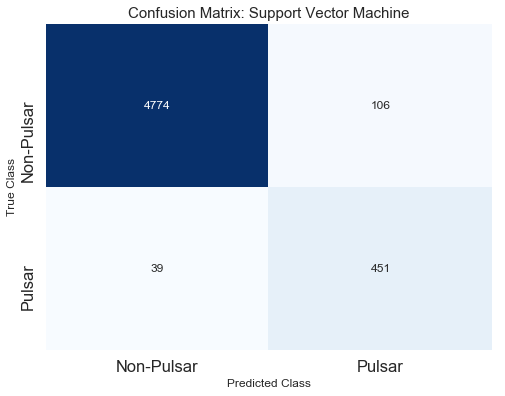

In [99]:
#Plot confustion matrix for Baseline SVM
plot_conf_matrix(y_test1, y_pred_svm, model_name='Support Vector Machine')

In [100]:
#Compute SVM Accuracy Score
svm_acc = round(svm.score(X_test1, y_test1),3)
print(f'SVM Accuracy: {svm_acc*100}%')
#Add score to dict and display
acc_scores['SVM'] = svm_acc
acc_scores

SVM Accuracy: 97.3%


{'model1': 0.974,
 'model2': 0.979,
 'model3': 0.978,
 'model4': 0.978,
 'model5': 0.979,
 'Decision Tree': 0.949,
 'Random Forest': 0.977,
 'SVM': 0.973}

### SVM Thoughts:
* SVM did also did pretty well on our data.  97.3% Accuracy.   Relatively high amount of FP but the lowest FN of any model.
* Feature importances cannot be determined using the RBF kernel.

## Machine Learning Recap
 * We did 4 Machine Learning models (2 Decision Trees, 1 Random Forest, 1 SVM) for the purpose of comparison to our Deep Learning Models.
 * In general, the models performed very well without diving into hyperparameter optimization.
 * With the exception of the SVM using RBF kernel, the models are much more interpretable that Deep Learning models where we can not suss out Feature Importance.
 * The 2 most important features of our Random Forest were the 2 mostly highly (and positively) correlated with the Target. A high Kurtosis or Skew of the IP for the candidate signals is a good indicator of a Pulsar Star. 

#### Let's look at Accuracy across all of our Models

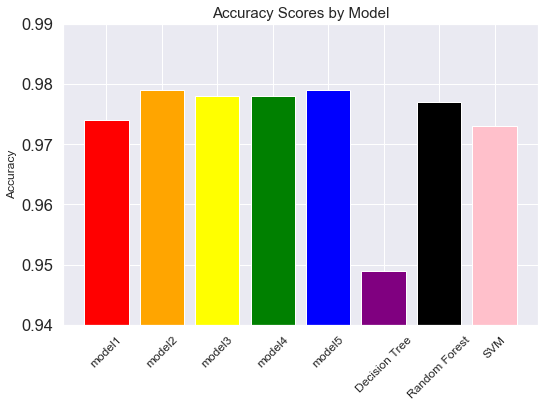

In [101]:
#Plot Accuracy Scores of our 8 models
plt.figure(figsize=(8,6))
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'pink']
plt.bar(list(acc_scores.keys()), acc_scores.values(), color=colors)
plt.ylim(0.94,0.99)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(list(acc_scores.keys()), rotation=45, ha='center', fontsize=12)
plt.title('Accuracy Scores by Model', fontsize=15)
plt.tight_layout()
plt.show()

## Conclusions
* We performed analysis and classification modeling on a dataset of Pulsar Star candidates.
* We trained the models on SMOTE upsampled data to make up for the unbalanced dataset - pulsar stars being a relatively rare occurence.  Test data was left untouched, leading the models to not predict the minority class as accurately as the majority class.
* We created 5 Deep Learning Models and 3 Machine Learning Models (plus a bonus 1-feature Decision Tree).
* The chart above shows that 7 of the 8 models acheived an accuracy score between 97 and 98%, topping out at 97.9% for a few of the Deep Learning models.  
* Limiting False Negatives took slight preference over False Positives in our experimenting.  That means that the star is a pulsar but we predict it is not.  Scientists could lose valuable insights by missing out on pulsar stars.  However, it is not a huge preference and the best model would minimize both and have a good balance.
* After tuning a few hyperparameters, adding layers and using regularization techniques did not improve the model in significant ways - it basically just shifted around the number Falst Negatives and False Positives.
* Feature importance in our Decision Tree and Random Forest modeling showed that features that correlated most positively with our Target (meaning higher values for pulsar stars) were most important for classification.  
* Such feature importance cannot be interpreted with our Deep Learning neural networks, so it was helpful to compare with the Machine Learning Models.
* Visualizations in the EDA section show that distributions for each of our features are pretty well separable by class, with a small overlap region that leads to what appears to be an upper limit of around 98% Accuracy.

### Future Work
* Gather more data to improve modeling.
* We ran a Decision Tree with just 1 feature, just because it was far and way the highest feature importance, but that idea could be applied to other models. If we can achieve similar (or superior) classification using fewer features it could speed up our modeling especially for computationally expensive algorithms and/or much larger datasets.
* Data collection could also potentially be streamlined if an optimal model is found using fewer features.